# Homework 6: Dask, Data Pipelines, and the Cloud

## 2. Dask background

### 2.1 What is Dask?

Dask is a parallel computing library in Python that scales the existing Python ecosystem (e.g., NumPy, pandas, scikit-learn) to larger datasets and multi-core or distributed environments. It provides dynamic task scheduling and high-level collections for parallel computing

### 2.2 What are the tradeoffs for using Dask vs Spark?

- Language: Dask is Python-native; Spark is written in Scala/Java with Python bindings (PySpark), leading to overhead
- Ease of use: Dask is more familiar to Python users and integrates better with NumPy/pandas
- Performance: Spark can be more performant for large-scale ETL on JVM clusters; Dask can be faster for in-memory operations on medium-sized clusters
- Ecosystem: Spark integrates better with big data tools (HDFS, Hive); Dask is better for scientific computing

### 2.3 What are the 3 main data structures in Dask and what do they scale?

- Dask Array: Scales NumPy arrays for numerical computations on large arrays.
- Dask DataFrame: Scales pandas DataFrames for tabular data processing.
- Dask Bag: Scales Python iterables (e.g., lists of dicts), used for unstructured or semi-structured data.

### 2.4 What are Dask Delayed and Dask Futures?

- Dask Delayed: Decorator-based API that lazily builds a task graph for arbitrary Python code.
- Dask Futures: Immediate, asynchronous parallel computing API using a distributed scheduler, allowing interactive parallelism.

### 2.5 What is Dask -ML and what does it scale? What is the advantage of using Dask-ML?

Dask-ML is a scalable machine learning library that parallels scikit-learn for larger-than-memory datasets.

Advantages:

- Enables distributed training.
- Integrates with Dask DataFrame and Array.
- Allows model selection and hyperparameter tuning at scale.

### 2.6  Explain how Lazy Evaluation works in Dask.

In Dask, computations are not executed immediately. Instead, Dask builds a task graph representing the operations. Execution happens only when you explicitly request a result using `.compute()`, enabling optimization and scheduling before execution.

## 3. Setup

### 3.1 Install

In [ ]:
!pip install dask

In [ ]:
!pip install dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.12.1
    Uninstalling dask-2024.12.1:
      Successfully uninstalled dask-2024.12.1
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.12.1
    Uninstalling distributed-2024.12.1:
      Successfully uninstalled distributed-2024.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rapids-dask-dependency 25.2.0 requires dask==2024.12.1, but you have dask 2025.4.1 which is incompatible.
rapids-dask-dependency 25.2.0 requires distributed==2024.12.1, bu

In [ ]:
!pip install kagglehub

### 3.2 Kaggle dataset

[Dataset in Kaggle](https://www.kaggle.com/api/v1/datasets/download/juice0lover/users-vs-bots-classification)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("juice0lover/users-vs-bots-classification")

print("Path to dataset files:", path)

100%|██████████| 110k/110k [00:00<00:00, 48.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/juice0lover/users-vs-bots-classification/versions/3


In [ ]:
print(path)

import os

os.listdir(path)

/root/.cache/kagglehub/datasets/juice0lover/users-vs-bots-classification/versions/3


['bots_vs_users.csv']

In [ ]:
import dask.dataframe as dd
import os

df = dd.read_csv(os.path.join(path, "bots_vs_users.csv"), dtype=str)

df.head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,Unknown,Unknown,Unknown,Unknown,Unknown


In [ ]:
total_rows = df.shape[0].compute()
print(total_rows)

5874


## 4. Data Cleaning

### 4.1 Repeat any data pre-processing/cleaning steps you needed to perform in Homework 5, but this time use Dask instead of Spark.

In [ ]:
# Count NaNs in each column
nan_counts = df.isna().sum().compute()
print(nan_counts)

has_domain                       0
has_birth_date                   0
has_photo                        0
can_post_on_wall                 0
can_send_message                 0
has_website                      0
gender                           0
has_short_name                   0
has_first_name                   0
has_last_name                    0
access_to_closed_profile         0
is_profile_closed                0
target                           0
has_nickname                     0
has_maiden_name                  0
has_mobile                       0
all_posts_visible                0
audio_available                  0
has_interests                    0
has_books                        0
has_tv                           0
has_quotes                       0
has_about                        0
has_games                        0
has_movies                       0
has_activities                   0
has_music                        0
can_add_as_friend                0
can_invite_to_group 

In [ ]:
# Group by all columns and count occurrences
duplicates = df.groupby(list(df.columns)).size().reset_index()

# Rename the count column
duplicates = duplicates.rename(columns={0: 'duplicates'})

# Filter rows with duplicates
duplicates = duplicates[duplicates['duplicates'] > 1]

# Compute and display
print(duplicates.compute())

Empty DataFrame
Columns: [has_domain, has_birth_date, has_photo, can_post_on_wall, can_send_message, has_website, gender, has_short_name, has_first_name, has_last_name, access_to_closed_profile, is_profile_closed, target, has_nickname, has_maiden_name, has_mobile, all_posts_visible, audio_available, has_interests, has_books, has_tv, has_quotes, has_about, has_games, has_movies, has_activities, has_music, can_add_as_friend, can_invite_to_group, subscribers_count, is_blacklisted, has_career, has_military_service, has_hometown, marital_status, has_universities, has_schools, has_relatives, is_verified, is_confirmed, has_status, posts_count, avg_likes, links_ratio, hashtags_ratio, avg_keywords, avg_text_length, attachments_ratio, avg_comments, reposts_ratio, ads_ratio, avg_views, posting_frequency_days, phone_numbers_ratio, avg_text_uniqueness, city, has_occupation, occupation_type_university, occupation_type_work, has_personal_data, duplicates]
Index: []

[0 rows x 61 columns]


In [ ]:
df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 60 entries, has_domain to has_personal_data
dtypes: string(60)

In [ ]:
binary_cols = ['has_photo', 'has_mobile', 'is_profile_closed', 'gender']

for col in binary_cols:
    print(f"Distinct values in '{col}':")
    print(df[col].dropna().unique().compute())
    print()

Distinct values in 'has_photo':
0        0.0
1        1.0
2    Unknown
Name: has_photo, dtype: string

Distinct values in 'has_mobile':
0    Unknown
1        1.0
2        0.0
Name: has_mobile, dtype: string

Distinct values in 'is_profile_closed':
0        0.0
1        1.0
2    Unknown
Name: is_profile_closed, dtype: string

Distinct values in 'gender':
0        1.0
1        2.0
2        0.0
3    Unknown
Name: gender, dtype: string



In [ ]:
import dask.dataframe as dd

numeric_cols = ['subscribers_count', 'avg_likes', 'avg_comments', 'avg_views', 'posts_count']

for col in numeric_cols:
    # Attempt to coerce to numeric; invalid parsing yields NaN
    coerced = dd.to_numeric(df[col], errors='coerce')

    # Identify entries where coercion failed but original value is not null
    invalid_mask = coerced.isna() & df[col].notnull()

    # Extract and display distinct invalid entries
    invalid_values = df[col][invalid_mask].dropna().unique().compute()

    print(f"Invalid entries in '{col}': {sorted(invalid_values.tolist())}")


Invalid entries in 'subscribers_count': ['Unknown']
Invalid entries in 'avg_likes': []
Invalid entries in 'avg_comments': []
Invalid entries in 'avg_views': []
Invalid entries in 'posts_count': []


In [ ]:
distinct_targets = df['target'].unique().compute()
print(distinct_targets)


0    1
1    0
Name: target, dtype: string


In [ ]:
import dask.dataframe as dd

# Calculate the proportion of missing values in each column
missing_ratios = df.isna().mean().compute()

# Identify columns where all values are missing
all_null_columns = missing_ratios[missing_ratios == 1.0].index.tolist()

# Drop columns with all missing values
df = df.drop(columns=all_null_columns)


In [ ]:
df = df.fillna('-1')


In [ ]:
import dask.dataframe as dd

# Identify string columns
string_cols = df.select_dtypes(include='string').columns

# Apply transformations to each string column
for col in string_cols:
    df[col] = df[col].str.lower().str.strip().mask(df[col].str.lower().str.strip() == 'unknown', '-1')


In [ ]:
import dask.dataframe as dd

# Identify columns with object dtype (typically strings)
string_cols = df.select_dtypes(include='string').columns

# print(string_cols[0:5])
# Iterate over each string column and display its distinct values
for col in string_cols[0:5]:
    unique_values = df[col].dropna().unique().compute()
    print(f"Distinct values in column '{col}': {sorted(unique_values.tolist())}")


Distinct values in column 'has_domain': ['-1', '1.0']
Distinct values in column 'has_birth_date': ['-1', '1.0']
Distinct values in column 'has_photo': ['-1', '0.0', '1.0']
Distinct values in column 'can_post_on_wall': ['-1', '0.0', '1.0']
Distinct values in column 'can_send_message': ['-1', '0.0', '1.0']


In [ ]:
import dask.dataframe as dd

# Identify columns with object dtype (typically strings)
string_cols = df.select_dtypes(include='string').columns

# Convert each string column to numeric, coercing errors to NaN
for col in string_cols:
    df[col] = dd.to_numeric(df[col], errors='coerce')


In [ ]:
df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 60 entries, has_domain to has_personal_data
dtypes: Int64(60)

In [ ]:
import dask.dataframe as dd

# Identify string (object) and numeric columns
string_cols = df.select_dtypes(include='object').columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Create a dictionary with appropriate fill values
fill_values = {col: '-1' for col in string_cols}
fill_values.update({col: -1 for col in numeric_cols})

# Apply fillna with the specified fill values
df = df.fillna(value=fill_values)

In [ ]:
df.head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
import numpy as np
# Compute mean and standard deviation
mean_val, std_val = dd.compute(df['avg_keywords'].mean(), df['avg_keywords'].std())

# Calculate Z-scores
df['z_score'] = (df['avg_keywords'] - mean_val) / std_val

# Identify outliers
outliers_df = df[np.abs(df['z_score']) > 3]

# Display statistics
print(f"Mean: {mean_val}")
print(f"Standard Deviation: {std_val}")

# Compute and display outliers
outliers = outliers_df.compute()
print(f"Number of outliers: {len(outliers)}")
print(outliers.head())

# Remove outliers
df = df[np.abs(df['z_score']) <= 3]


Mean: 1.0674753149472251
Standard Deviation: 6.624632017819347
Number of outliers: 154
     has_domain  has_birth_date  has_photo  can_post_on_wall  \
948         1.0             1.0        1.0               0.0   
952         1.0            -1.0        1.0               0.0   
961         1.0            -1.0        1.0               0.0   
963         1.0            -1.0        1.0               0.0   
988         1.0            -1.0        1.0               1.0   

     can_send_message  has_website  gender  has_short_name  has_first_name  \
948               0.0          0.0     2.0             1.0             1.0   
952               1.0          0.0     2.0             1.0             1.0   
961               0.0          0.0     2.0             1.0             1.0   
963               0.0          0.0     1.0             1.0             1.0   
988               1.0          0.0     1.0             1.0             1.0   

     has_last_name  ...  avg_views  posting_frequency_days 

In [ ]:
grouped_counts = df.groupby('target').size().compute()
print(grouped_counts)

target
0    2925
1    2795
dtype: int64


In [ ]:
null_counts = df.isnull().sum().compute()
print(null_counts)

has_domain                    0
has_birth_date                0
has_photo                     0
can_post_on_wall              0
can_send_message              0
                             ..
has_occupation                0
occupation_type_university    0
occupation_type_work          0
has_personal_data             0
z_score                       0
Length: 61, dtype: int64


## 5. Machine Learning

### 5.1 Split your data into testing and training datasets (80% train, 20% test), Fit your chosen model to the training data, Make predictions on the previously unseen test data.

In [ ]:
from dask.distributed import Client
import joblib
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score


In [ ]:
# Initialize Dask Client
client = Client()

# Define feature columns (excluding 'target' and 'city')
feature_cols = [col for col in df.columns if col not in ['target', 'city']]

# Separate features and target
X = df[feature_cols]
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26, shuffle=True)

# Create a pipeline with a scaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=26,
        n_jobs=-1
    ))
])

# Fit the model using Dask's joblib backend
with joblib.parallel_backend('dask'):
    pipeline.fit(X_train.compute(), y_train.compute())

# Make predictions
predictions = pipeline.predict(X_test.compute())

# Evaluate the model
accuracy = accuracy_score(y_test.compute(), predictions)
roc_auc = roc_auc_score(y_test.compute(), predictions)

print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test ROC-AUC: {roc_auc:.3f}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45439
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40455'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42345'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:33339 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33339
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34670
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:35551 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35551
INFO:distributed.core:Starting established connection to tcp://127

Test Accuracy: 0.969
Test ROC-AUC: 0.969


### 5.2 How did you do? Show how, both in code (be sure to print) and in words you measure success and what your chosen metric(s) mean.

- Accuracy = 0.969

  - It means that 96.9% of test instances were correctly classified at the default 0.5 threshold.

- ROC-AUC = 0.969

  - With 96.9% probability the model ranks a random positive sample higher than a random negative one

Together, with this scores we can say that the forest separates the classes really good on the held out data, while maintaining a high threshold for the hit rate.

## 6. Data Pipelines

### 6.1 What is a data pipeline?

It is a series of automated, repeatable steps that process data from its raw state form to a final deliverable output, such as cleaned dataset, analytical model input or report. Each step in the pipeline performs a specific task (e.g. ingestion, cleaning, transformation, modeling, evaluation) and passes its output to the next step.

### 6.2  Why do data scientists need to know about data pipelines?

Data scientists need to understand data pipelines to ensure that their workflows are scalable, maintainable and reproducible. Pipelines help automate the flow of data from source to model, reduce manual errors, improve collaboration with engineering teams, and allow for faster iteration and deployment of data driven solutions.

### 6.3 Take the code you write in Step 5 “Machine Learning” and rewrite it in a modular fashion that maps to a data pipeline structure (see Lecture 13 slides - Each stage is a function and the pipeline is a function → modular, repeatable, testable).

In [ ]:
import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib
import numpy as np

def start_dask_client():
    return Client()

def load_data(path):
    return dd.read_csv(path)

def prepare_features(df, exclude_cols=['target', 'city']):
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    X = df[feature_cols]
    y = df['target']
    return X, y

def split_data(X, y, test_size=0.2, seed=26):
    return train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=True)

def build_pipeline():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=26, n_jobs=-1))
    ])

def train_model(pipeline, X_train, y_train):
    with joblib.parallel_backend('dask'):
        return pipeline.fit(X_train.compute(), y_train.compute())

def evaluate_model(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test.compute())
    y_true = y_test.compute()
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return acc, auc

def pipeline(df):
    client = start_dask_client()
    df = df
    X, y = prepare_features(df)
    X_train, X_test, y_train, y_test = split_data(X, y)
    pipe = build_pipeline()
    model = train_model(pipe, X_train, y_train)
    accuracy, auc = evaluate_model(model, X_test, y_test)
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Test ROC-AUC:  {auc:.3f}")

# Run the pipeline
pipeline(df)

/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39839 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:34799
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:39839/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43653'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36189'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:43627 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43627
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:39628
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:42143 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42143
IN

Test Accuracy: 0.969
Test ROC-AUC:  0.969


## 7. Airflow

### 7.1 What is Apache Airflow?

It's an open source workflow orchastration tool used to programmatically author, schedule, and monitor data workflows (DAGs). Each task in a workflow is defined as a node in a Directed Acyclic Graph (DAG), and Airflow handles dependencies, execution order, retries, logging, and schedulling.

### 7.2 What type of workflow is Airflow good for? How is this different from  Streaming workloads?

Airflow is best suited for batch workflows, which run on a defined schedule (e.g. hourly, daily, weekly) or in response to specific events. These workflows process datasets in discrete chunks rather than in real time.

On the ohter hand, streaming workloads operate on continuous data flows (e.g. Kafka streams) and require low-latency, event-driven processing. Airflow is not designed for real-time or low-latency streaming workloads.

### 7.3  What is TaskFlow in Apache Airflow? How does it work and what benefit does it provide?

TaskFlow is a decorator-based API in Airflow that simplifies DAG authoring by allowing you to write Python functions as tasks. Instead of defining operators and XComs explicitly, you can write regular Python functions and use the `@task` decorator. Airflow handles passing outputs as inputs between tasks using XComs automatically.

The main benefits are:

- Cleaner, more readable code
- Better encapsulation of logic in Python functions
- Easier testing and debugging

### 7.4  Describe,‬‭ in words‬‭ , what Taskflow would enable you to do with the DaskML pipeline you created in‬‭ Step 6‬‭“Data Pipelines” (‬‭ you don’t have to write‬ the actual code‬‭ .

TaskFlow would allow us to convert each function in the modular Dask ML pipeline (e.g. data loading, preprocessing, training, evaluation, etc) into a clearly defined task within an Airflow DAG. It would automatically manage the execution order and data flow between tasks without requiring manual XCom definitions. This makes the entire pipeline:

- Modular and logically separated
- Schedulable and automatable as part of recurring job
- Monitorable, with retries and logging handle by Airflow
- Scalable, allowing integrations with other data sources or postprocessing steps like model deployment or reporting

## 8. Cloud

### 8.1 What is the cloud?

The cloud refers to on-demand access to computing resources (e.g. storage, servers, databases, analytics, ML services) over the internet from a cloud provider like AWS, Google Cloud or Azure. Users can scale, manage and pay for resources as needed without owning any physical hardware.

### 8.2 What does the cloud do for Data Scientists?

The cloud gives data scientists scalable, elastic access to powerful computation tools, storage and services. This allows us to:

- Train large ML models using GPUs/TPUs
- Store and query massive datasets efficiently
- Run reproducible workflows (e.g. Airflow pipelines)
- Collaborate across teams and environments
- Integrate with managed services

### 8.3 Suppose we wanted to run our Dask ML pipeline using Airflow as described above in Step 7 “Airflow”. What would it mean to do this in the cloud (for example, if we were to run it on AWS ), and what are the pros and cons of a managed Ariflow service like MWAA ?

Running the Dask ML pipeline in the cloud means deploying the pipeline and its scheduler (Airflow in this particular case) on cloud infrastructure. On AWS, this mean using EC2 instances for Dask workers and using Amazon MWAA (Managed Workflows for Apache Airflow) for orchestration.

Pros of using a managed service like MWAA:

- Security compliance: built-in IAM integration, VPC support and logging
- Scalability: it automatically can handle workload scaling with some configurations
- Integration with AWS services ecosystem: easy connection to S3, Redshift, EMR, SageMaker, etc
- No infrastructure managment per se: AWS manages the Airflow environment (like updates, patches, scaling)

Cons:

- Cost: managed services can tend to be more expensive than self-hosted ones
- Less flexible: limited control over certain configurations (plugins, system packages)
- Cold start latency: tasks might have startup delays compared to always on setups
- Service limits: MWAA could have constraints on DAG size, execution time or even environment customization

Running our Dask ML pipeline in MWAA on AWS provide a robust, production ready orchestration platform without the operation overhead, but at the cost of control and potentially more expenses.

## 9. Optional: Extra Credit

### 9.1 Airflow setup

In [ ]:
!pip install apache-airflow==2.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of apache-airflow-providers-common-sql to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of apache-airflow-providers-common-sql to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of apache-airflow-providers-ftp to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of apache-airflow-providers-ftp 

In [ ]:
!pip install apache-airflow-providers-sqlite

In [ ]:
!pip install "pendulum<3.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.0/490.0 kB 13.4 MB/s eta 0:00:00
  Created wheel for pendulum: filename=pendulum-2.1.2-cp311-cp311-manylinux_2_35_x86_64.whl size=158476 sha256=391cac093e44e374544151dc2eb376ddbd9d7c80d6018a85acb66bce905533ea
  Stored in directory: /root/.cache/pip/wheels/a4/b7/10/a86f4f49b1bdf8a0cf3da42d48f499e4cb7529ebab7aad3550
Successfully built pendulum
  Attempting uninstall: pendulum
    Found existing installation: pendulum 3.1.0
    Uninstalling pendulum-3.1.0:
      Successfully uninstalled pendulum-3.1.0


In [ ]:
!pip install "apache-airflow[webserver]==2.5.0"

In [ ]:
!pip install "Flask-Session==0.4.0"

  Attempting uninstall: Flask-Session
    Found existing installation: Flask-Session 0.3.2
    Uninstalling Flask-Session-0.3.2:
      Successfully uninstalled Flask-Session-0.3.2


In [ ]:
!pip install "connexion[swagger-ui]<3.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: swagger-ui-bundle
    Found existing installation: swagger_ui_bundle 1.1.0
    Uninstalling swagger_ui_bundle-1.1.0:
      Successfully uninstalled swagger_ui_bundle-1.1.0
  Attempting uninstall: connexion
    Found existing installation: connexion 3.2.0
    Uninstalling connexion-3.2.0:
      Successfully uninstalled connexion-3.2.0


In [ ]:
!airflow version

2.5.0


In [ ]:
!airflow db check

[2025-05-12 07:24:18,899] {cli_action_loggers.py:125} WARNING - Failed to log action with (sqlite3.OperationalError) no such table: log
[SQL: INSERT INTO log (dttm, event, owner, extra) VALUES (?, ?, ?, ?)]
[parameters: ('2025-05-12 07:24:18.895452', 'cli_check', 'root', '{"host_name": "1937fc79d031", "full_command": "[\'/usr/local/bin/airflow\', \'db\', \'check\']"}')]
(Background on this error at: https://sqlalche.me/e/14/e3q8)
[2025-05-12 07:24:18,901] {db.py:1720} INFO - Connection successful.


In [ ]:
import os

os.environ['AIRFLOW__CORE__LOAD_EXAMPLES'] = 'False'
os.environ['AIRFLOW__WEBSERVER__WEB_SERVER_PORT'] = '8081'
os.environ['AIRFLOW__CORE__EXECUTOR'] = 'SequentialExecutor'

In [ ]:
!airflow db init

DB: sqlite:////root/airflow/airflow.db
[2025-05-12 07:24:27,277] {migration.py:207} INFO - Context impl SQLiteImpl.
[2025-05-12 07:24:27,280] {migration.py:210} INFO - Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running stamp_revision  -> 290244fb8b83
WARNI [airflow.models.crypto] empty cryptography key - values will not be stored encrypted.
Initialization done


In [ ]:
!mkdir -p ~/airflow/dags/

In [ ]:
!ls ~/airflow/dags/

In [ ]:
!ls ~/airflow/

airflow.cfg  airflow.db  dags


In [ ]:
!sed -i 's/^load_examples = .*/load_examples = False/' ~/airflow/airflow.cfg
!sed -i 's/^web_server_port = .*/web_server_port = 8081/' ~/airflow/airflow.cfg
!sed -i 's/^executor *= *.*/executor = SequentialExecutor/' ~/airflow/airflow.cfg

In [ ]:
!cat ~/airflow/airflow.cfg

[core]
# The folder where your airflow pipelines live, most likely a
# subfolder in a code repository. This path must be absolute.
#
# Variable: AIRFLOW__CORE__DAGS_FOLDER
#
dags_folder = /root/airflow/dags

# Hostname by providing a path to a callable, which will resolve the hostname.
# The format is "package.function".
# 
# For example, default value ``airflow.utils.net.getfqdn`` means that result from patched
# version of `socket.getfqdn() <https://docs.python.org/3/library/socket.html#socket.getfqdn>`__,
# see related `CPython Issue <https://github.com/python/cpython/issues/49254>`__.
# 
# No argument should be required in the function specified.
# If using IP address as hostname is preferred, use value ``airflow.utils.net.get_host_ip_address``
#
# Variable: AIRFLOW__CORE__HOSTNAME_CALLABLE
#
hostname_callable = airflow.utils.net.getfqdn

# A callable to check if a python file has airflow dags defined or not and should
# return ``True`` if it has dags otherwise ``False``.
# If this

In [ ]:
!airflow config get-value core load_examples

False


In [ ]:
!airflow config get-value core executor

SequentialExecutor


In [ ]:
!airflow webserver -p 8081 -D

!airflow scheduler -D

!airflow dag-processor -D

!airflow triggerer -D

  ____________       _____________
 ____    |__( )_________  __/__  /________      __
____  /| |_  /__  ___/_  /_ __  /_  __ \_ | /| / /
___  ___ |  / _  /   _  __/ _  / / /_/ /_ |/ |/ /
 _/_/  |_/_/  /_/    /_/    /_/  \____/____/|__/
Running the Gunicorn Server with:
Workers: 4 sync
Host: 0.0.0.0:8081
Timeout: 120
Logfiles: - -
Access Logformat: 
[2025-05-12 07:28:05,422] {dagbag.py:538} INFO - Filling up the DagBag from /dev/null
[2025-05-12 07:28:05,802] {manager.py:824} WARNING - No user yet created, use flask fab command to do it.
[2025-05-12 07:28:13,980] {manager.py:504} INFO - Created Permission View: can read on DAGs
[2025-05-12 07:28:14,017] {manager.py:504} INFO - Created Permission View: can edit on DAGs
[2025-05-12 07:28:14,114] {manager.py:504} INFO - Created Permission View: can delete on DAGs
[2025-05-12 07:28:14,497] {manager.py:504} INFO - Created Permission View: can read on Datasets
[2025-05-12 07:28:14,646] {manager.py:504} INFO - Created Permission View: can read

### 9.2 DAG creation

In [ ]:
%%writefile ~/airflow/dags/hello.py
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime

def say_hello():
    print("Hello, World!")

with DAG(
    dag_id='hello_world_dag',
    start_date=datetime(2025, 5, 12),
    schedule=None,
    catchup=False,
    tags=['example'],
) as dag:
    hello_task = PythonOperator(
        task_id='say_hello',
        python_callable=say_hello
    )

Overwriting /root/airflow/dags/hello.py


In [ ]:
!ls ~/airflow/dags/

hello.py  __pycache__


In [ ]:
!airflow dags reserialize

[2025-05-12 07:29:19,259] {dagbag.py:538} INFO - Filling up the DagBag from /root/airflow/dags
[2025-05-12 07:29:19,323] {dag.py:2676} INFO - Sync 1 DAGs
[2025-05-12 07:29:19,340] {dag.py:3423} INFO - Setting next_dagrun for hello_world_dag to None, run_after=None


### 9.3 Trigger your DAG

In [ ]:
!airflow dags unpause hello_world_dag

Dag: hello_world_dag, paused: False


In [ ]:
!airflow dags trigger hello_world_dag

[2025-05-12 07:29:32,649] {__init__.py:42} INFO - Loaded API auth backend: airflow.api.auth.backend.session
Created <DagRun hello_world_dag @ 2025-05-12T07:29:33+00:00: manual__2025-05-12T07:29:33+00:00, state:queued, queued_at: 2025-05-12 07:29:33.466288+00:00. externally triggered: True>


### 9.4  Show that your pipeline task (job ) was successful

In [ ]:
from airflow import settings
from airflow.models import TaskInstance

session = settings.Session()
tasks = session.query(TaskInstance).filter(TaskInstance.dag_id == 'hello_world_dag').all()

for task in tasks:
    print(f'Task {task.task_id} in DAG {task.dag_id} has status: {task.state}')

Task say_hello in DAG hello_world_dag has status: success


## 10. Optional: Extra Credit

### 10.1 Take the Dask ML pipeline code you wrote in Step 6 and create a DAG definition file that turns it into an Airflow DAG of tasks/jobs.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("juice0lover/users-vs-bots-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/users-vs-bots-classification


In [ ]:
print(path)

import os

os.listdir(path)

/kaggle/input/users-vs-bots-classification


['bots_vs_users.csv']

In [ ]:
%%writefile ~/airflow/dags/dask_ml_modular_pipeline.py
from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.utils.dates import days_ago
from dask.distributed import Client
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib
import os

path = "/kaggle/input/users-vs-bots-classification"
DATA_PATH = os.path.join(path, "bots_vs_users.csv")
TMP_DIR = '/tmp/airflow_dask_pipeline'

os.makedirs(TMP_DIR, exist_ok=True)

def start_dask_client():
    Client()

def load_data(**kwargs):
    df = dd.read_csv(DATA_PATH, dtype=str)
    df = df.fillna('-1')
    # Identify string columns
    string_cols = df.select_dtypes(include='string').columns

    # Apply transformations to each string column
    for col in string_cols:
        df[col] = df[col].str.lower().str.strip().mask(df[col].str.lower().str.strip() == 'unknown', '-1')

    string_cols = df.select_dtypes(include='string').columns

    # Convert each string column to numeric, coercing errors to NaN
    for col in string_cols:
        df[col] = dd.to_numeric(df[col], errors='coerce')

      # Identify string (object) and numeric columns
    string_cols = df.select_dtypes(include='object').columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Create a dictionary with appropriate fill values
    fill_values = {col: '-1' for col in string_cols}
    fill_values.update({col: -1 for col in numeric_cols})

    # Apply fillna with the specified fill values
    df = df.fillna(value=fill_values)
    joblib.dump(df, os.path.join(TMP_DIR, 'df.pkl'))

def prepare_features(**kwargs):
    df = joblib.load(os.path.join(TMP_DIR, 'df.pkl'))
    exclude = ['target', 'city']
    feature_cols = [col for col in df.columns if col not in exclude]
    X, y = df[feature_cols], df['target']
    joblib.dump(X, os.path.join(TMP_DIR, 'X.pkl'))
    joblib.dump(y, os.path.join(TMP_DIR, 'y.pkl'))

def split_data(**kwargs):
    X = joblib.load(os.path.join(TMP_DIR, 'X.pkl'))
    y = joblib.load(os.path.join(TMP_DIR, 'y.pkl'))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
    joblib.dump(X_train, os.path.join(TMP_DIR, 'X_train.pkl'))
    joblib.dump(X_test, os.path.join(TMP_DIR, 'X_test.pkl'))
    joblib.dump(y_train, os.path.join(TMP_DIR, 'y_train.pkl'))
    joblib.dump(y_test, os.path.join(TMP_DIR, 'y_test.pkl'))

def train_model(**kwargs):
    Client()
    X_train = joblib.load(os.path.join(TMP_DIR, 'X_train.pkl')).compute()
    y_train = joblib.load(os.path.join(TMP_DIR, 'y_train.pkl')).compute()
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=26, n_jobs=-1))
    ])
    with joblib.parallel_backend('dask'):
        pipeline.fit(X_train, y_train)
    joblib.dump(pipeline, os.path.join(TMP_DIR, 'model.pkl'))

def evaluate_model(**kwargs):
    model = joblib.load(os.path.join(TMP_DIR, 'model.pkl'))
    X_test = joblib.load(os.path.join(TMP_DIR, 'X_test.pkl')).compute()
    y_test = joblib.load(os.path.join(TMP_DIR, 'y_test.pkl')).compute()
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.3f}")
    print(f"Test ROC-AUC:  {auc:.3f}")

with DAG(
    dag_id='dask_ml_modular_pipeline',
    start_date=days_ago(1),
    schedule_interval=None,
    catchup=False,
) as dag:

    t1 = PythonOperator(task_id='start_dask', python_callable=start_dask_client)
    t2 = PythonOperator(task_id='load_data', python_callable=load_data)
    t3 = PythonOperator(task_id='prepare_features', python_callable=prepare_features)
    t4 = PythonOperator(task_id='split_data', python_callable=split_data)
    t5 = PythonOperator(task_id='train_model', python_callable=train_model)
    t6 = PythonOperator(task_id='evaluate_model', python_callable=evaluate_model)

    t1 >> t2 >> t3 >> t4 >> t5 >> t6


Overwriting /root/airflow/dags/dask_ml_modular_pipeline.py


In [ ]:
!airflow dags reserialize

[2025-05-12 08:11:13,455] {dagbag.py:538} INFO - Filling up the DagBag from /root/airflow/dags
[2025-05-12 08:11:14,427] {utils.py:162} INFO - NumExpr defaulting to 2 threads.
[2025-05-12 08:11:17,619] {dag.py:2676} INFO - Sync 2 DAGs
[2025-05-12 08:11:17,645] {dag.py:3423} INFO - Setting next_dagrun for dask_ml_modular_pipeline to None, run_after=None
[2025-05-12 08:11:17,648] {dag.py:3423} INFO - Setting next_dagrun for hello_world_dag to None, run_after=None


In [ ]:
!airflow dags unpause dask_ml_modular_pipeline

Dag: dask_ml_modular_pipeline, paused: False


In [ ]:
!airflow dags trigger dask_ml_modular_pipeline

[2025-05-12 08:11:27,036] {__init__.py:42} INFO - Loaded API auth backend: airflow.api.auth.backend.session
Created <DagRun dask_ml_modular_pipeline @ 2025-05-12T08:11:27+00:00: manual__2025-05-12T08:11:27+00:00, state:queued, queued_at: 2025-05-12 08:11:27.819714+00:00. externally triggered: True>


In [ ]:
!airflow dags state dask_ml_modular_pipeline 2025-05-12T08:11:27+00:00


success


## 11. Optional: Extra Credit

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok config add-authtoken 2wyt7vccPvYknCpa4N9MshZwgub_61HEPJXwmNpWx6ipTLfA2

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!airflow users create \
  --username admin \
  --password admin \
  --firstname Admin \
  --lastname User \
  --role Admin \
  --email admin@example.com

[2025-05-12 07:48:07,178] {manager.py:824} WARNING - No user yet created, use flask fab command to do it.
[2025-05-12 07:48:15,525] {manager.py:212} INFO - Added user admin
User "admin" created with role "Admin"


In [ ]:
!ngrok http 8081 --log=stdout

INFO[05-12|08:11:44] no configuration paths supplied 
INFO[05-12|08:11:44] using configuration at default config path path=/root/.config/ngrok/ngrok.yml
INFO[05-12|08:11:44] open config file                         path=/root/.config/ngrok/ngrok.yml err=nil
t=2025-05-12T08:11:44+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
t=2025-05-12T08:11:45+0000 lvl=info msg="client session established" obj=tunnels.session
t=2025-05-12T08:11:45+0000 lvl=info msg="tunnel session started" obj=tunnels.session
t=2025-05-12T08:11:45+0000 lvl=info msg="started tunnel" obj=tunnels name=command_line addr=http://localhost:8081 url=https://533d-34-125-233-230.ngrok-free.app
t=2025-05-12T08:11:48+0000 lvl=info msg="join connections" obj=join id=16b9fb3952bd l=127.0.0.1:8081 r=100.15.131.58:61613
t=2025-05-12T08:11:48+0000 lvl=info msg="join connections" obj=join id=e86f67977bd9 l=127.0.0.1:8081 r=100.15.131.58:61613
t=2025-05-12T08:11:48+0000 lvl=info msg="join connectio

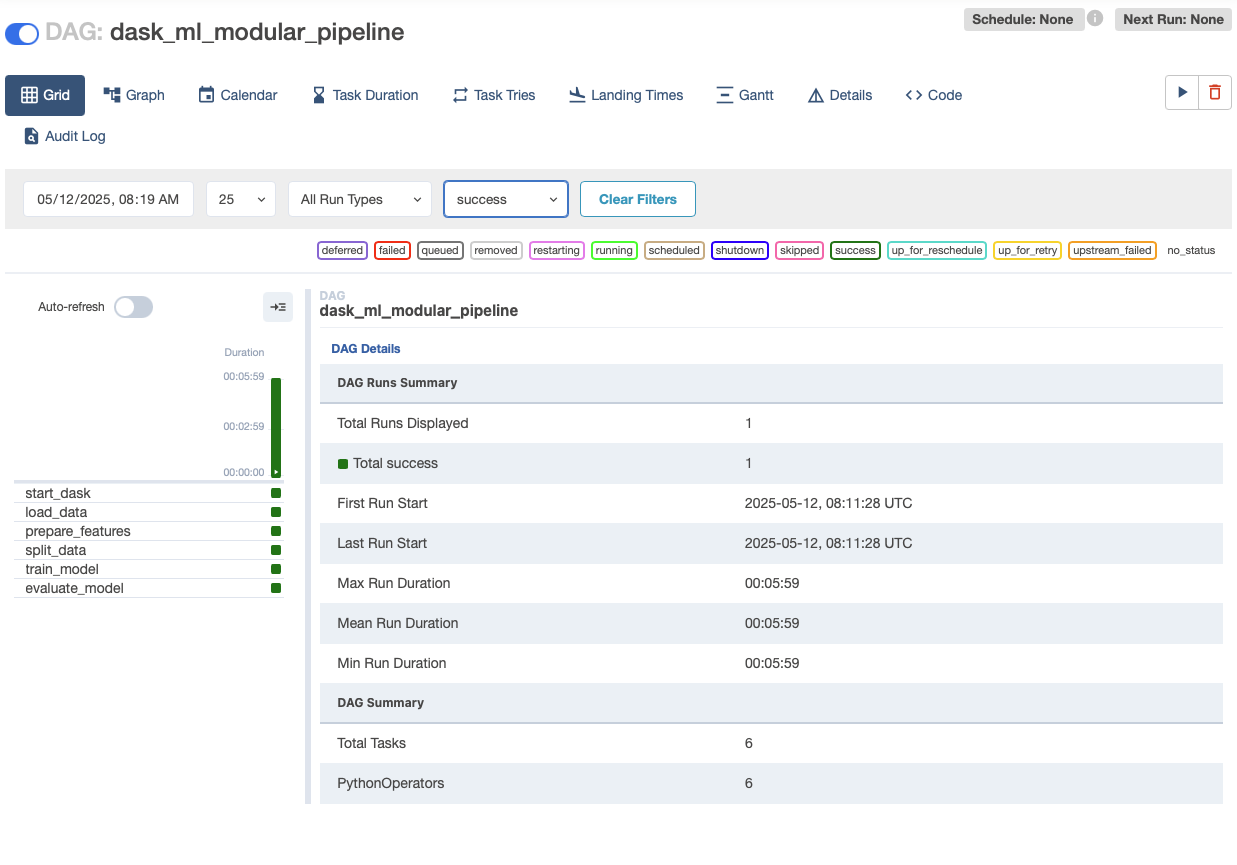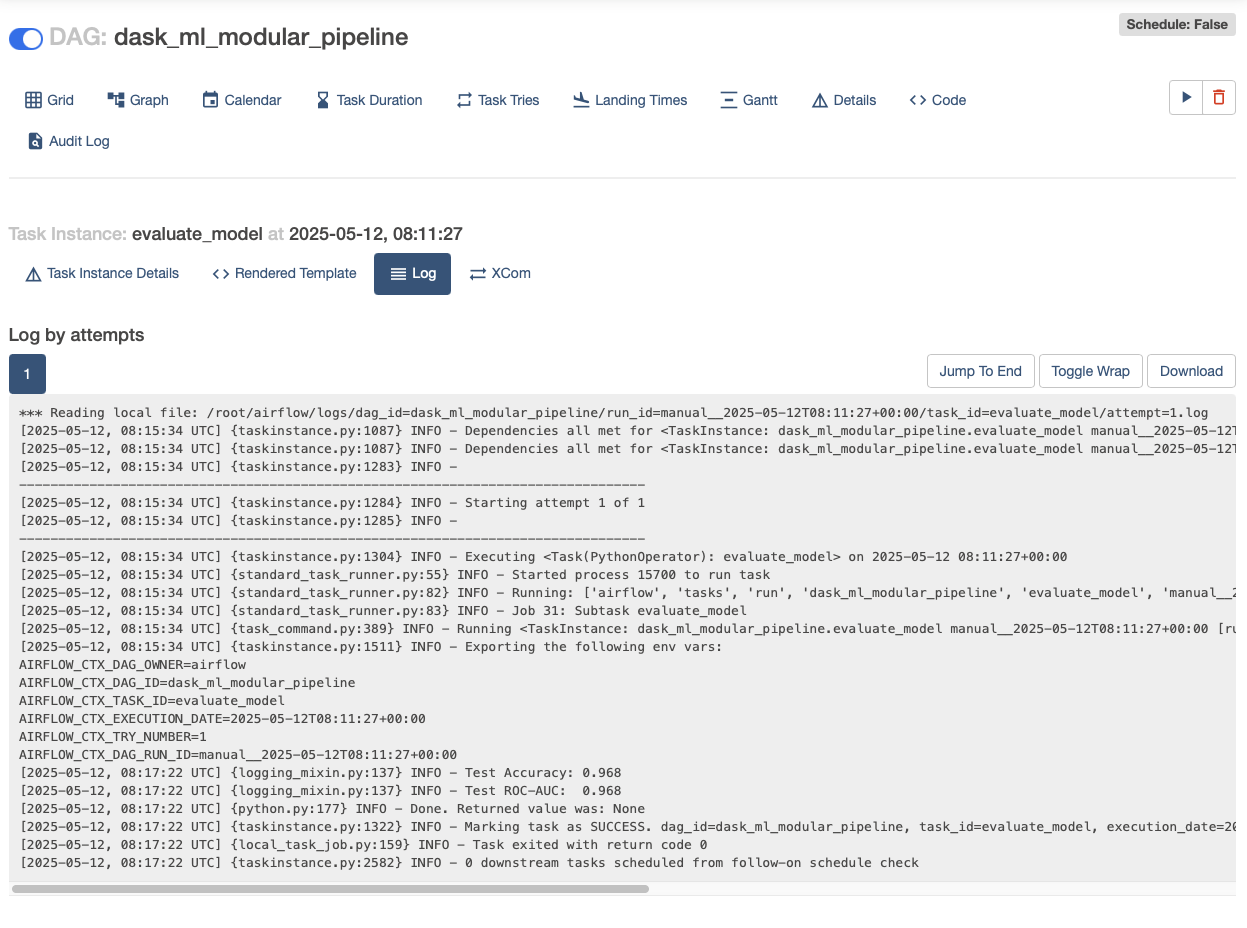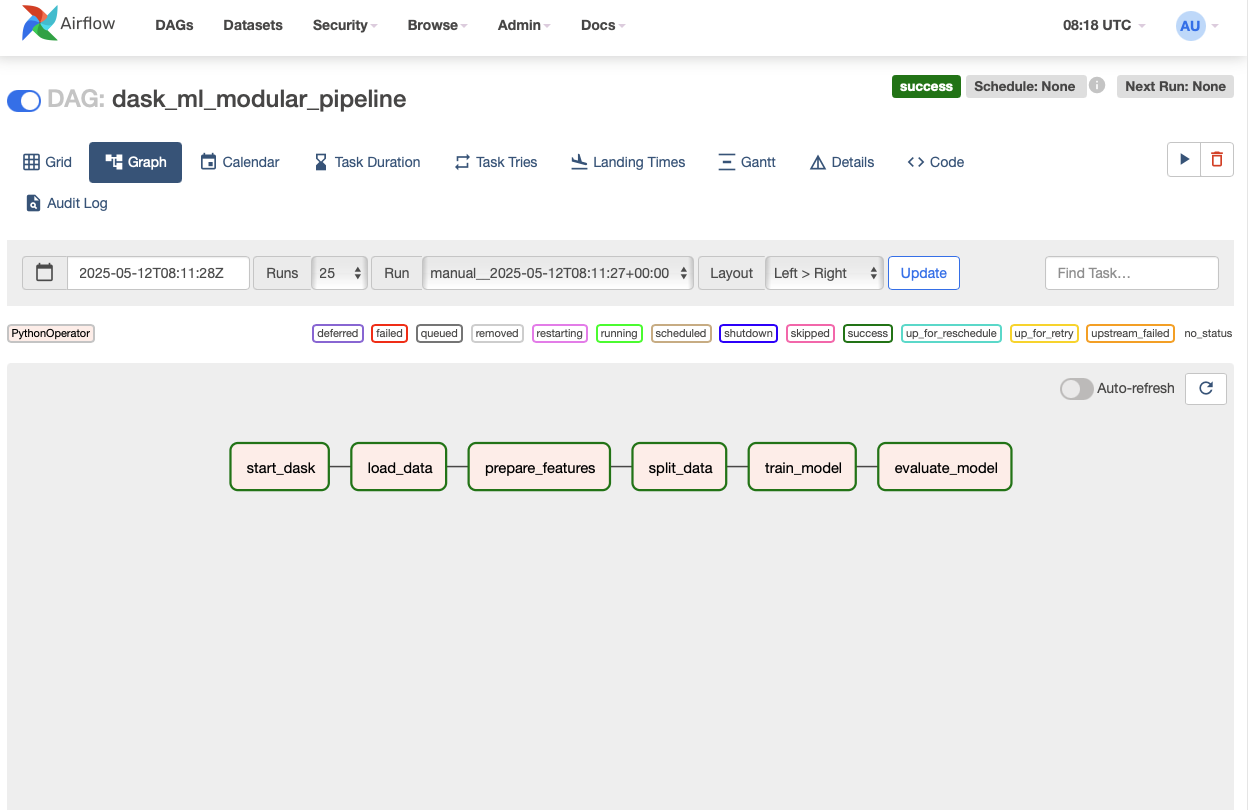